In [ ]:
!pip install deeplake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.9/608.9 kB 31.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#import deeplake
from PIL import Image

In [ ]:
ds_train = deeplake.load("hub://activeloop/emnist-letters-train")
ds_test = deeplake.load("hub://activeloop/emnist-letters-test")

|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/emnist-letters-train



|

hub://activeloop/emnist-letters-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/emnist-letters-test



/

hub://activeloop/emnist-letters-test loaded successfully.



In [ ]:
def extract_data(ds):
    image = np.array([image.numpy() for image in ds["images"]])
    label = np.array([label.numpy() for label in ds["labels"]])
    return image, label

x_train, y_train = extract_data(ds_train)
x_test, y_test = extract_data(ds_test)

# Combine datasets to create a larger pool for splitting
x_combined = np.concatenate((x_train, x_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x_combined, y_combined, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.6, random_state=42)

# Normalize images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [ ]:
# Reshape data to include channel dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
unique_labels = np.unique(y_train)
print("Unique labels in the dataset:", unique_labels)

Unique labels in the dataset: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


In [ ]:
# Reshape labels to be 1D
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
# Ensure labels are integers
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [ ]:
# Debugging: print shapes and types
print("x_train shape:", x_train.shape, "x_train type:", x_train.dtype)
print("y_train shape:", y_train.shape, "y_train type:", y_train.dtype)

x_train shape: (72800, 28, 28, 1) x_train type: float64
y_train shape: (72800,) y_train type: int64


In [ ]:
# Mapping of label indices to letters
labels_map = [chr(i) for i in range(ord('a'), ord('z')+1)]  # ['a', 'b', ..., 'z']

def show_sample_images(images, labels, num_samples=10):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        label_index = labels[i]
        label_char = labels_map[label_index - 1]
        plt.title(f'{label_char}')
        plt.axis('off')
    plt.show()

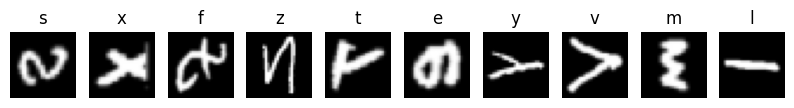

In [ ]:
# Show some sample images and their labels
show_sample_images(x_train, y_train)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential([
    # CNN layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Flatten(),

    # Dropout layer to reduce overfitting
    layers.Dropout(0.5),

    # Dense layer to reduce dimension for RNN input
    layers.Dense(576, activation='relu'),  # 24x24 = 576
    layers.Reshape(target_shape=(24, 24)),  # Reshape to (24, 24) or another valid shape

    # RNN layers
    layers.LSTM(64, return_sequences=True, activation='relu'),
    layers.LSTM(64, activation='relu'),

    # Output layer
    layers.Dense(27, activation='softmax')  # 27 classes for EMNIST letters
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.5062 - loss: 1.6229 - val_accuracy: 0.8845 - val_loss: 0.3529
Epoch 2/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.8621 - loss: 0.4265 - val_accuracy: 0.9124 - val_loss: 0.2546
Epoch 3/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8878 - loss: 0.3349 - val_accuracy: 0.9246 - val_loss: 0.2263
Epoch 4/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9013 - loss: 0.2935 - val_accuracy: 0.9272 - val_loss: 0.2181
Epoch 5/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9123 - loss: 0.2573 - val_accuracy: 0.9343 - val_loss: 0.2009
Epoch 6/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9197 - loss: 0.2381 - val_accuracy: 0.9344 - val_loss: 0.2002
Epoch 7/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9218 - loss: 0.2266 - val_accuracy: 0.9323 - val_loss: 0.2037
Epoch 8/20
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9250 - loss: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, x_data, y_data, data_type="Data"):
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred, average='macro')
    recall = recall_score(y_data, y_pred, average='macro')
    f1 = f1_score(y_data, y_pred, average='macro')

    print(f'{data_type} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# Evaluate on training data
evaluate_model(model, x_train, y_train, "Training")

# Evaluate on validation data
evaluate_model(model, x_val, y_val, "Validation")

# Evaluate on testing data
evaluate_model(model, x_test, y_test, "Testing")

2275/2275 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Training - Accuracy: 0.9573076923076923, Precision: 0.9594250848188743, Recall: 0.9577674550150914, F1 Score: 0.9577823608227602
910/910 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Validation - Accuracy: 0.9417925824175825, Precision: 0.9425821627155139, Recall: 0.9403602841638199, F1 Score: 0.9403773830560372
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Testing - Accuracy: 0.9391025641025641, Precision: 0.9407772288066293, Recall: 0.9392377752314596, F1 Score: 0.9390603698176457


In [ ]:
model.save('emnist_OCR_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('emnist_OCR_model.h5')

In [ ]:
def load_and_preprocess_image(image_path):
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28 pixels
    img = np.array(img)  # Convert to numpy array

    # Normalize the image
    img = img / 255.0

    # Reshape to match the input shape expected by the model
    img = img.reshape(1, 28, 28, 1)

    return img

# Example usage
custom_image_path = '/content/emnist_W.png'
custom_image = load_and_preprocess_image(custom_image_path)



In [ ]:
# Predict the letter
predictions = model.predict(custom_image)
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicted class: {predicted_class[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: 23


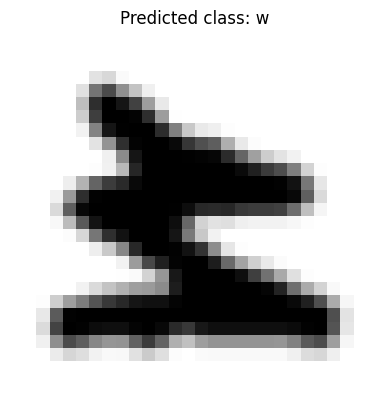

In [ ]:
plt.imshow(custom_image.reshape(28, 28), cmap='gray')
predicted_char = labels_map[predicted_class[0] - 1]
plt.title(f'Predicted class: {predicted_char}')
plt.axis('off')
plt.show()
